In [ ]:
rm(list = ls())
gc()

setwd("/mnt/data00/minghui/project_NMF/06_Test_NMF_Program_0213/")
library(Seurat)
library(dplyr)
library(cowplot)
library(harmony)
library(readr) 
library(tidyr)
library(gplots)
library(reshape2)
library(paletteer)
library(AUCell)
library(pheatmap)
suppressPackageStartupMessages(library(NMF))
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(scibet))
suppressMessages(library(viridis))
suppressMessages(library(ggsci))
 
d_palettes<- palettes_d_names
mycol<-paletteer_d( "ggsci::default_igv",n=51)

# source('../Fuctions/Markers_kno.R')
# source('../Fuctions/seurat_functions.R')

library(ComplexHeatmap)
library(circlize)

library(scater)


library(htmlwidgets)

library(GSVA)

library(corrplot)


library(patchwork)


In [3]:
AllTissue_merge <-readRDS('../02_NMFAllTissue/03_AllTissue_merge.rds')

In [ ]:
source('/mnt/data00/minghui/Fuctions/seurat_functions.R')

split_list <- readRDS('/mnt/data00/minghui/project_NMF/02_NMFAllTissue/01_split_list.rds')

samplename_list <- readRDS("../04_Test_NMF_Program_0120/02_samplename_list.rds")

res_optima_L <- readRDS('/mnt/data00/minghui/project_NMF/02_NMFAllTissue/03_res_optima_L.rds')

In [4]:
library(ggrepel)

# Function to generate UMAP plot for each module
plot_umap_for_module <- function(module_name) {
  # Calculate AUCell for the module
  AUCell_auc <- as.numeric(getAUC(cells_AUC)[module_name, ])
  # Add to metadata
  data$AUCell <- AUCell_auc
  
  # Extract UMAP coordinates data
  umap <- data.frame(data@meta.data, data@reductions$umap@cell.embeddings)
  
  # Calculate median coordinates for each cell type
  cell_type_med <- umap %>%
    dplyr::group_by(cell_type) %>%
    summarise(
      UMAP_1 = median(UMAP_1),
      UMAP_2 = median(UMAP_2)
    )
  
  # Generate plot
  p <- ggplot(umap, aes(UMAP_1, UMAP_2)) +
    geom_point(aes(colour = AUCell)) +
    scale_colour_gradientn(colours = custom_palette(100)) + # Apply custom color palette    theme_bw() +
    ggtitle(paste("UMAP Plot for Module:", module_name))
  
}

# NMF 

In [ ]:
samplename_list

In [ ]:
new_sample_list <- list(c(samplename_list$Healthy_stomach,samplename_list$Healthy_intestine),samplename_list$BE_sample_names)

names(new_sample_list) <- c('healthy','BE')

new_sample_list

In [ ]:
new_sample_list$healthy

In [ ]:
Healthy_res_optima_L <- res_optima_L[new_sample_list$healthy]

Healthy_res_optima_L <- Filter(Negate(is.null), Healthy_res_optima_L)

Healthy_modules.list = lapply(Healthy_res_optima_L, NMFToModules)

all = unlist(Healthy_modules.list, recursive = FALSE, use.names = FALSE)

names(all) = unlist(sapply(Healthy_modules.list, names))
ta = table(unlist(all))
genes.use = names(ta)[ta > 1]

# names((Healthy_stomach_modules.list)

for (i in 1:5){
  all = unlist(Healthy_modules.list, recursive = FALSE, use.names = TRUE)
  all = lapply(all, intersect, genes.use)
  sim = sapply(all, function(x){
    sapply(all, function(y){
      length(intersect(x,y))/length(union(x,y))
    })
  })
  keep = rownames(sim)[apply(sim, 1, function(x){
    # sum(x > 0.05) >= 5
    sum(x > 0.05) >= 2
  })]
  all = all[keep]
  modules.list = lapply(names(Healthy_modules.list), function(x){
    li = Healthy_modules.list[[x]]
    li[names(li)[paste(x,names(li),sep='.') %in% keep]]
  })
  names(Healthy_modules.list) =  names(Healthy_res_optima_L)
  ta = table(unlist(all))
  genes.use = names(ta)[ta > 1] 
  print(length(all))
}
# Filter the modules in the similarity matrix and keep those modules whose similarity coefficient with at least 5 other modules is greater than 0.05
pheatmap(sim,scale =T ,show_rownames= F, show_colnames = F)

In [ ]:
sub = matrix(0, nrow = length(genes.use), ncol = length(genes.use))
  rownames(sub) = genes.use
  colnames(sub) = genes.use
  for (s in names(Healthy_modules.list)){
    for (mod in Healthy_modules.list[[s]]){
      mod = intersect(mod, genes.use)
      for (x in mod){
        for (y in mod){
          sub[x,y] = sub[x,y] + 1
        }
      }
    }
  }
  diag(sub) = 0
adj_keep = sub


v_min = 3 # from 3 to 2 

s_min = 3 # from 2 to 1 

adj = adj_keep 

adj[] = (adj >= v_min) 

for (i in 1:5){ 
    keep = names(which(rowSums(adj) >= s_min))
    adj = adj[keep,keep] 
    print(dim(adj))
}

In [ ]:
g = graph_from_adjacency_matrix(adj, diag = FALSE, mode = 'undirected', weighted = TRUE)
Healthy_modules = communities(cluster_infomap(g, nb.trials = 200))
names(Healthy_modules) = paste0('m_', sapply(Healthy_modules, '[', 1))


my_lengths <- sapply(Healthy_modules, length)

Healthy_modules <- subset(Healthy_modules, my_lengths > 2)

 a <-lapply(Healthy_modules, list)
Healthy_modules <-lapply(a, unlist)

In [ ]:
length(Healthy_modules)

In [ ]:
names(Healthy_modules) <- paste0('Healthy_module',seq(1:length(Healthy_modules)))

In [ ]:
saveRDS(Healthy_modules , './01_Healthy_modules.rds')

In [ ]:
Healthy_modules

In [ ]:
Healthy_modules <-readRDS('./01_Healthy_modules.rds')

#  AUCell

In [ ]:
DefaultAssay(AllTissue_merge)

options(repr.plot.width =7, repr.plot.height=5)

exprMatrix <- AllTissue_merge@assays$RNA@counts

cells_rankings <- AUCell_buildRankings(exprMatrix)

cells_AUC <- AUCell_calcAUC(Healthy_modules, cells_rankings, aucMaxRank=nrow(cells_rankings)*0.05) ## calculate AUC values 

cells_assignment <- AUCell_exploreThresholds(cells_AUC, plotHist=TRUE, nCores=5,assign=TRUE)## selecte thresholds 


In [17]:
custom_palette <- colorRampPalette(c("#440154FF", "#20938CFF", "#FDE725FF"))
data <- AllTissue_merge
plots <- lapply(names(Healthy_modules), plot_umap_for_module) 

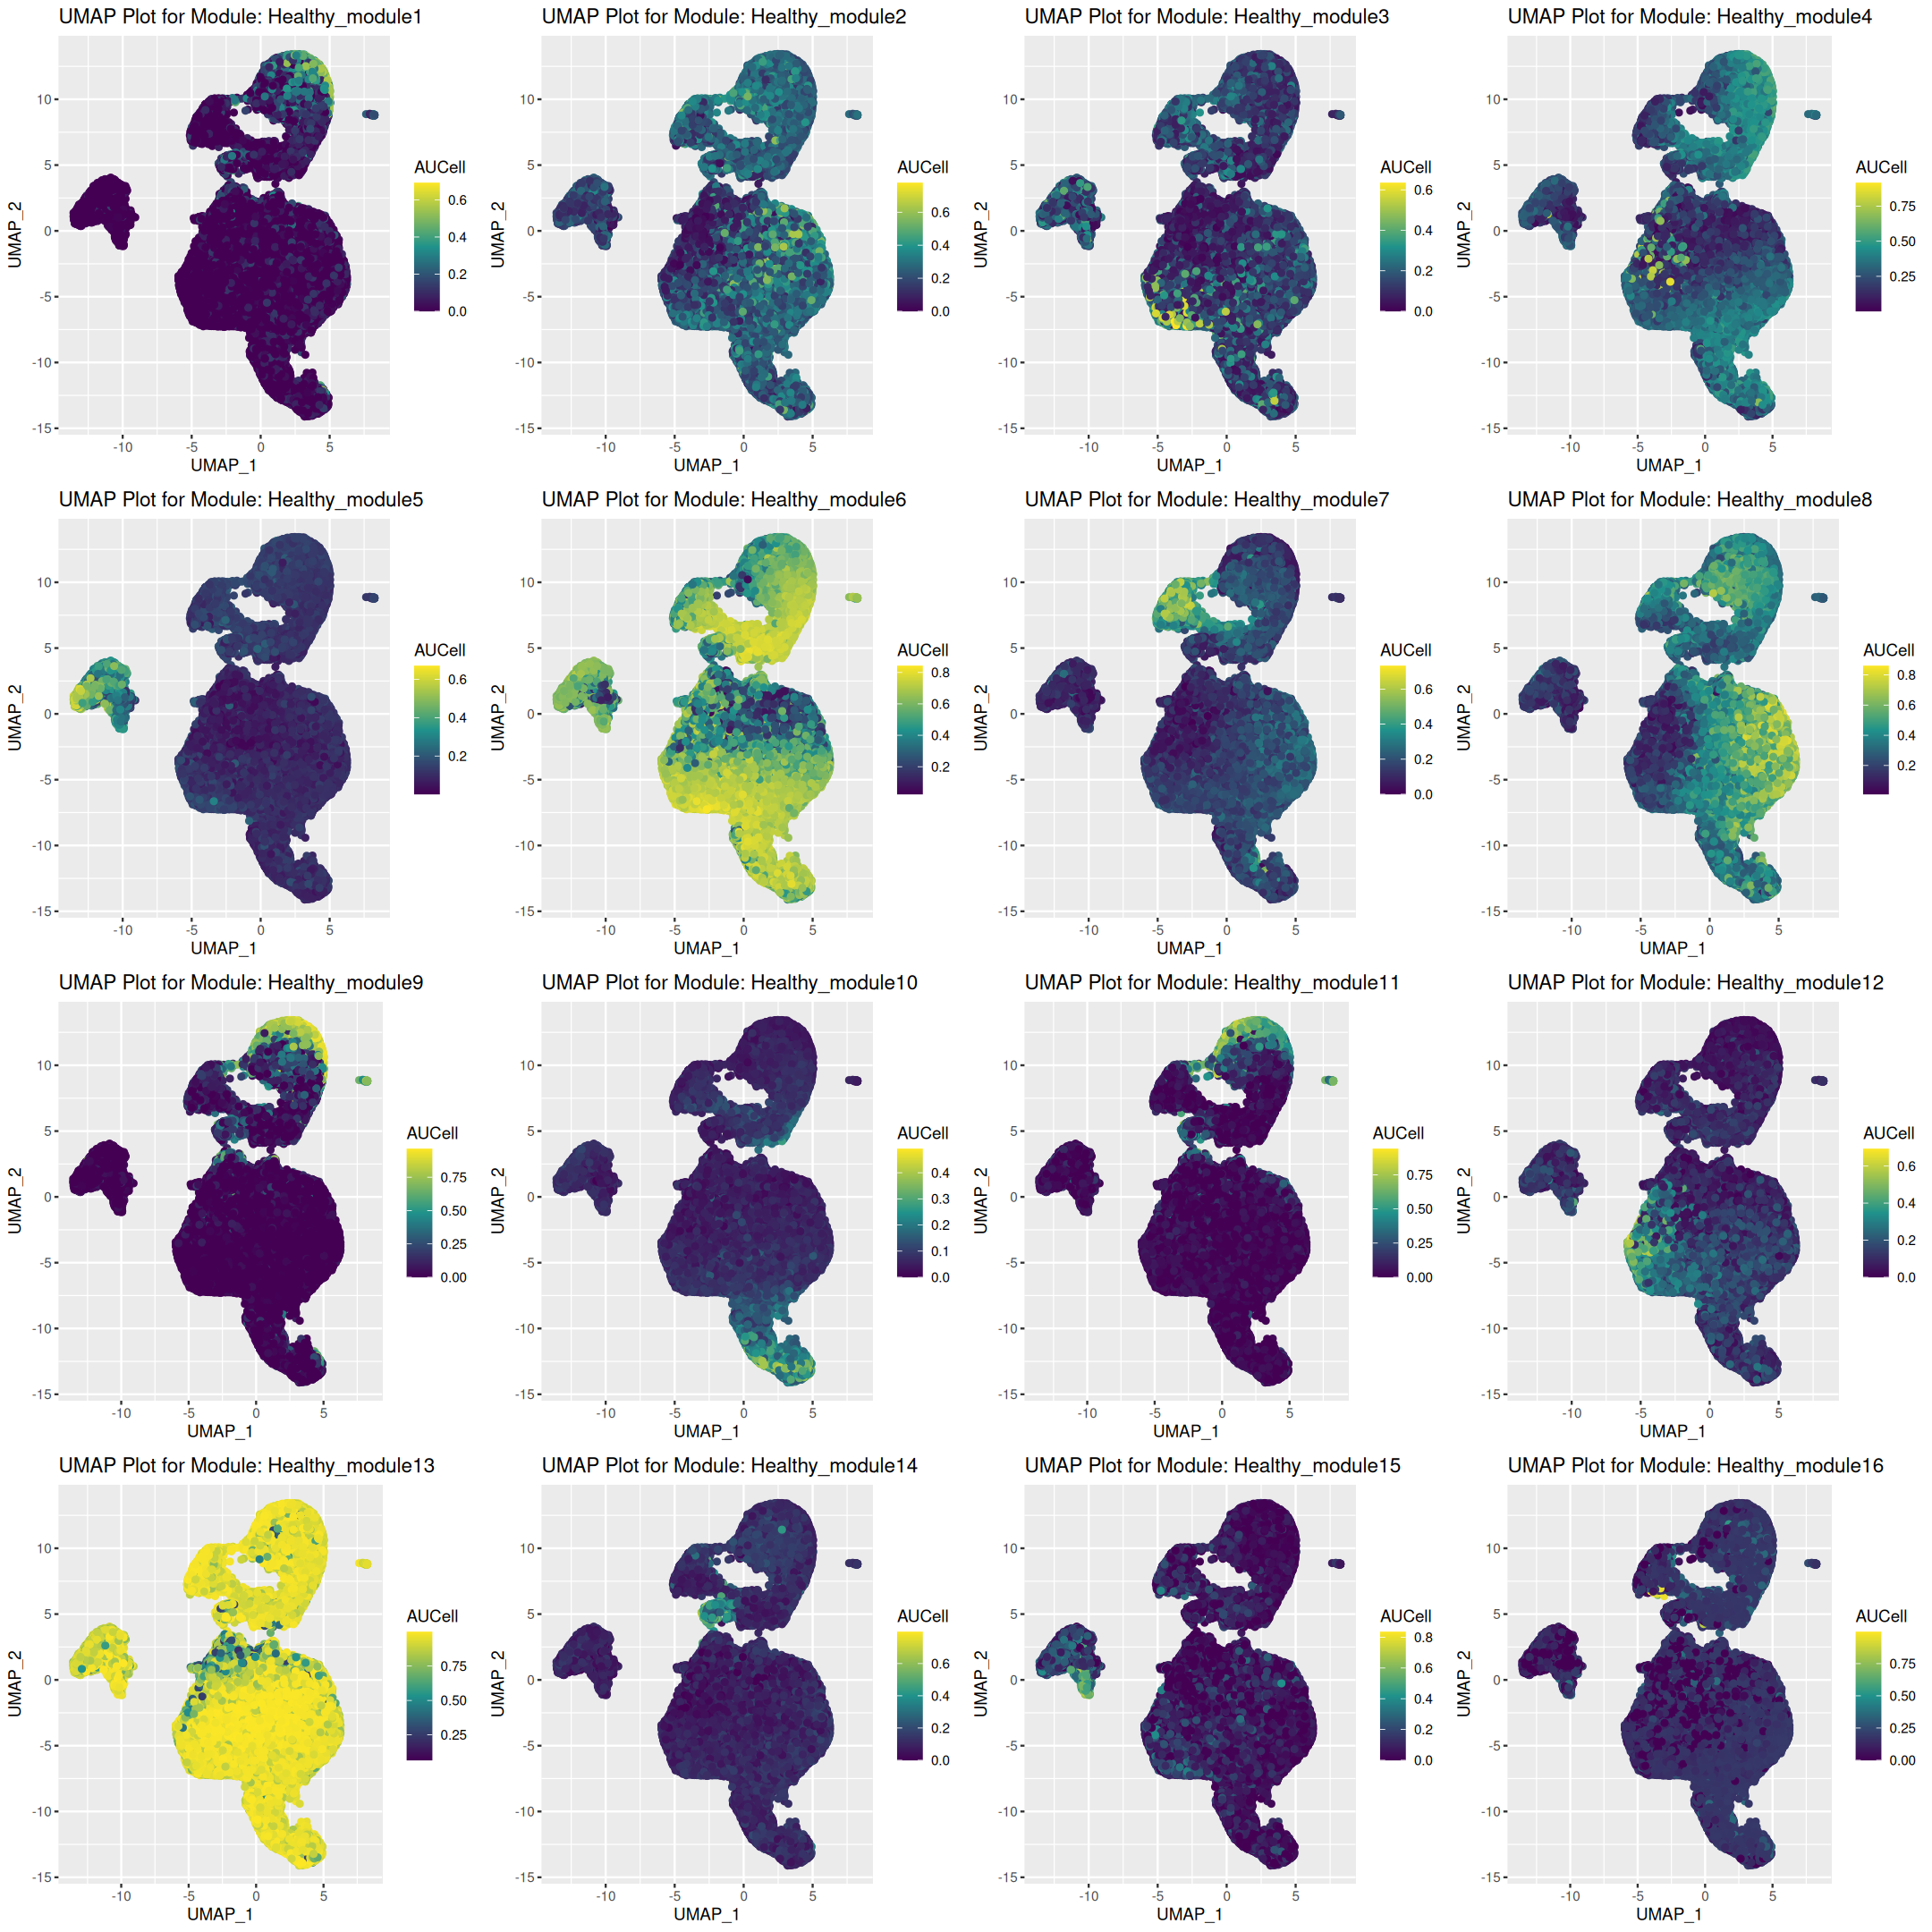

In [18]:
options(repr.plot.width =18, repr.plot.height=18)

plot_grid(plotlist = plots,ncol = 4)

In [23]:
png('./01_Module_UMAP_AUCell.png',width = 16,height = 16,units = 'in',res = 300)
plot_grid(plotlist = plots,ncol = 4)
dev.off()

pdf 
  2

# cor heatmap 

In [24]:
moduleScore <- getAUC(cells_AUC)

cor_matrix <- cor(t(moduleScore) , method = "spearman")

p_matrix <- cor.mtest(t(moduleScore) , method = "spearman")$p

In [25]:
saveRDS(moduleScore, './02_Healthy_moduleScore.rds')

In [26]:
as.data.frame(cor_matrix)

Healthy_module1 Healthy_module2 Healthy_module3
Healthy_module1   1.00000000      0.12071997     -0.11038014    
Healthy_module2   0.12071997      1.00000000      0.31982253    
Healthy_module3  -0.11038014      0.31982253      1.00000000    
Healthy_module4   0.26490235      0.01745160     -0.10912822    
Healthy_module5   0.13318767      0.04617280      0.13362480    
Healthy_module6  -0.07654790     -0.03518942      0.14832765    
Healthy_module7  -0.10974171      0.21549141      0.14400732    
Healthy_module8   0.08729050      0.39232064      0.11486519    
Healthy_module9   0.46902614      0.03857568     -0.18887714    
Healthy_module10 -0.20768362     -0.03998736      0.14085493    
Healthy_module11  0.36109005      0.06270706     -0.12875496    
Healthy_module12 -0.22052107     -0.01986026      0.09969469    
Healthy_module13  0.11966233      0.29299997      0.01956329    
Healthy_module14  0.16821572      0.18032559      0.07910381    
Healthy_module15 -0.09192949      0.10502599      0.04335304    
Healthy_module16  0.23663960      0.03234921     -0.12195778    
                 Healthy_module4 Healthy_module5 Healthy_module6
Healthy_module1   0.264902350     0.133187674    -0.07654790    
Healthy_module2   0.017451599     0.046172805    -0.03518942    
Healthy_module3  -0.109128218     0.133624796     0.14832765    
Healthy_module4   1.000000000     0.290374807     0.66830945    
Healthy_module5   0.290374807     1.000000000     0.25916041    
Healthy_module6   0.668309452     0.259160414     1.00000000    
Healthy_module7   0.130979214     0.026499554     0.19152443    
Healthy_module8   0.001475529    -0.354829677    -0.18590925    
Healthy_module9   0.304507307     0.328204044    -0.03946201    
Healthy_module10  0.372531681    -0.008519697     0.54384236    
Healthy_module11  0.108950873     0.323586131    -0.18312679    
Healthy_module12  0.177940415     0.089808904     0.42655097    
Healthy_module13  0.205323904     0.255257859     0.11887772    
Healthy_module14  0.275116770     0.180077953     0.17350596    
Healthy_module15 -0.070273912     0.258040709     0.04844828    
Healthy_module16  0.476597331     0.132695583     0.29571657    
                 Healthy_module7 Healthy_module8 Healthy_module9
Healthy_module1  -0.109741709     0.087290498     0.46902614    
Healthy_module2   0.215491410     0.392320641     0.03857568    
Healthy_module3   0.144007320     0.114865192    -0.18887714    
Healthy_module4   0.130979214     0.001475529     0.30450731    
Healthy_module5   0.026499554    -0.354829677     0.32820404    
Healthy_module6   0.191524431    -0.185909250    -0.03946201    
Healthy_module7   1.000000000     0.431991896    -0.20211862    
Healthy_module8   0.431991896     1.000000000    -0.26220555    
Healthy_module9  -0.202118623    -0.262205548     1.00000000    
Healthy_module10  0.170660524     0.028324115    -0.24634951    
Healthy_module11 -0.195544522    -0.158634551     0.59973897    
Healthy_module12  0.245070410     0.030623783    -0.31626568    
Healthy_module13  0.169714404     0.050063036     0.14784138    
Healthy_module14  0.197010077     0.210642759     0.14063002    
Healthy_module15 -0.008870901    -0.198144135    -0.07324680    
Healthy_module16  0.048977650    -0.063359435     0.38317784    
                 Healthy_module10 Healthy_module11 Healthy_module12
Healthy_module1  -0.207683623      0.36109005      -0.22052107     
Healthy_module2  -0.039987356      0.06270706      -0.01986026     
Healthy_module3   0.140854927     -0.12875496       0.09969469     
Healthy_module4   0.372531681      0.10895087       0.17794041     
Healthy_module5  -0.008519697      0.32358613       0.08980890     
Healthy_module6   0.543842359     -0.18312679       0.42655097     
Healthy_module7   0.170660524     -0.19554452       0.24507041     
Healthy_module8   0.028324115     -0.15863455       0.03062378     
Healthy_module9  -0.246349506      0.59973897      -0.31626568     
Healthy_module10  1.00

In [27]:
saveRDS(cor_matrix , './02_cor_matrix_AUC.rds')

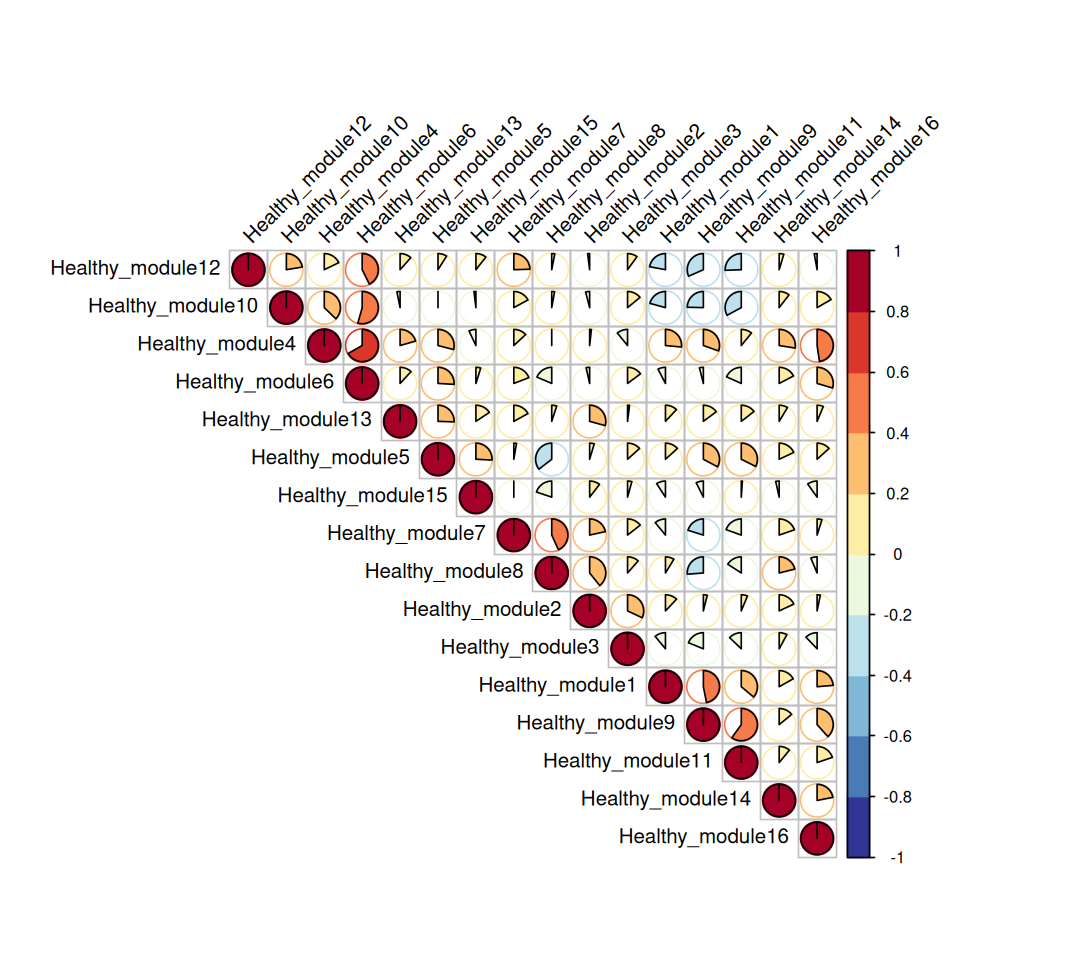

In [44]:
# threshold <- 0.3

# cor_matrix[abs(cor_matrix) <= threshold | p_matrix >= 0.05] <- 0

my_color = rev(paletteer_d("RColorBrewer::RdYlBu"))
my_color = colorRampPalette(my_color)(10) 

# pdf('./02_Heatmap_AUC_1.pdf',width = 8,height = 7)

# png('./02_Heatmap_AUC_1.png',width = 8,height = 7,units = 'in',res =500)
options(repr.plot.width =9, repr.plot.height=8)

corrplot(cor_matrix, type = "upper", 
         method = "pie",
         order = "hclust", 
         col = my_color,
         tl.col = "black", 
         tl.srt = 45)
# dev.off()

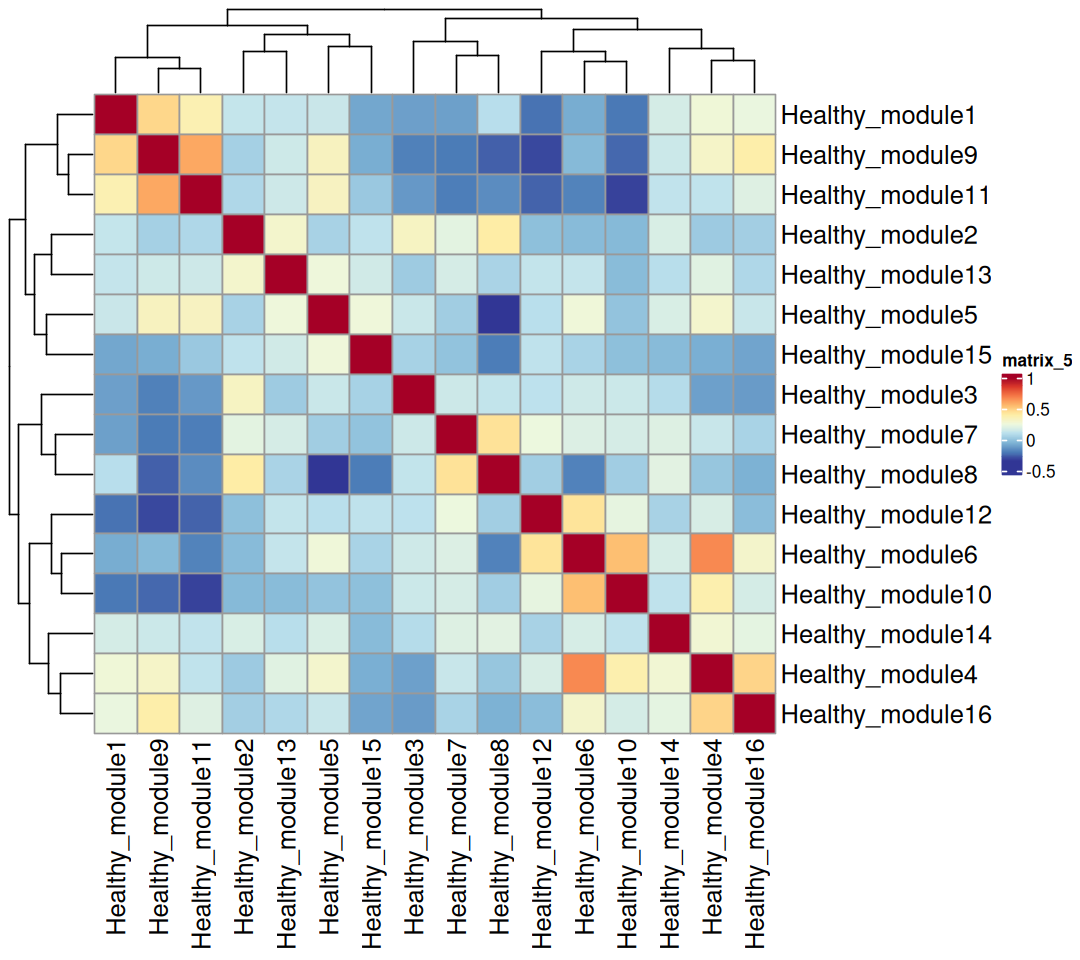

In [47]:
# dev.off()
options(repr.plot.width =9, repr.plot.height=8)
# pdf('./02_Heatmap_AUC_2.pdf',width = 8,height = 7)

# png('./02_Heatmap_AUC_2.png',width = 8,height = 7,units = 'in',res =500)

pheatmap(cor_matrix,color =my_color ,fontsize_row = 15,fontsize_col = 15)
# dev.off()

# Scatter plot

In [56]:
BE_moduleScore <-readRDS("/mnt/data00/minghui/project_NMF/04_Test_NMF_Program_0120/05_moduleScore.rds") %>% t()%>% as.data.frame

BE_moduleScore <- BE_moduleScore[,grepl(pattern = 'BE',x = colnames(BE_moduleScore))]

colnames(BE_moduleScore) <- gsub('modules','module',colnames(BE_moduleScore) )

head(BE_moduleScore )

BE_module1 BE_module3 BE_module4 BE_module5
SRR8513799-CTCACACGTCACCCAG-1 0.1550850  0.2526822  0.06129739 0.2188196 
SRR8513799-TACAGTGGTCATCCCT-1 0.1316673  0.2318313  0.19529913 0.2978776 
SRR8513799-GCACATACACTGTCGG-1 0.1674745  0.1851385  0.16516075 0.2135012 
SRR8513799-CTGAAACTCTGGCGAC-1 0.1839847  0.1943278  0.14726983 0.3199673 
SRR8513799-AGTAGTCAGTGAAGAG-1 0.1839111  0.2218957  0.15750608 0.1803542 
SRR8513799-ATCCGAACAACGATGG-1 0.1229569  0.2474111  0.34851259 0.1746896 
                              BE_module6 BE_module7 BE_module8 BE_module10
SRR8513799-CTCACACGTCACCCAG-1 0.2493345  0.4448295  0.1777360  0.6041700  
SRR8513799-TACAGTGGTCATCCCT-1 0.2890661  0.5235595  0.1272618  0.3631629  
SRR8513799-GCACATACACTGTCGG-1 0.3029051  0.5326612  0.1636309  0.3497916  
SRR8513799-CTGAAACTCTGGCGAC-1 0.2393197  0.4522159  0.1175674  0.2070269  
SRR8513799-AGTAGTCAGTGAAGAG-1 0.2302345  0.3631240  0.1599127  0.3584437  
SRR8513799-ATCCGAACAACGATGG-1 0.4248046  0.6117062  0.3250188  0.3044256  
                              BE_module11 BE_module12 BE_module14 BE_module15
SRR8513799-CTCACACGTCACCCAG-1 0.16490311  0.16345655  0.16250000  0.7843992  
SRR8513799-TACAGTGGTCATCCCT-1 0.12318697  0.11749382  0.09530201  0.8194613  
SRR8513799-GCACATACACTGTCGG-1 0.11810447  0.14177169  0.09052013  0.8098503  
SRR8513799-CTGAAACTCTGGCGAC-1 0.29442714  0.11704758  0.10461409  0.8323738  
SRR8513799-AGTAGTCAGTGAAGAG-1 0.07611450  0.06846771  0.00000000  0.7419980  
SRR8513799-ATCCGAACAACGATGG-1 0.07648053  0.04707230  0.19236577  0.4978345  
                              BE_module16 BE_module17 BE_module18 BE_module19
SRR8513799-CTCACACGTCACCCAG-1 0.18755441  0.1980326   0.9714024   0.3293303  
SRR8513799-TACAGTGGTCATCCCT-1 0.19878126  0.2211749   0.9418884   0.3262650  
SRR8513799-GCACATACACTGTCGG-1 0.17566716  0.2338687   0.9772823   0.2670166  
SRR8513799-CTGAAACTCTGGCGAC-1 0.20832708  0.1673095   0.9882021   0.1861432  
SRR8513799-AGTAGTCAGTGAAGAG-1 0.10911656  0.5118768   0.9741896   0.2280495  
SRR8513799-ATCCGAACAACGATGG-1 0.07057305  0.5531151   0.9891566   0.0408566  
                              BE_module21
SRR8513799-CTCACACGTCACCCAG-1 0.3863923  
SRR8513799-TACAGTGGTCATCCCT-1 0.2179756  
SRR8513799-GCACATACACTGTCGG-1 0.3791379  
SRR8513799-CTGAAACTCTGGCGAC-1 0.1988469  
SRR8513799-AGTAGTCAGTGAAGAG-1 0.3802069  
SRR8513799-ATCCGAACAACGATGG-1 0.4649307

In [57]:
# mat <- rbind(rbind(AllTissue_merge@meta.data$Tissue_in_paper , moduleScore),AllTissue_merge@meta.data$Detailed_Cell_Type)

Healthy_df <- cbind(data.frame(       'Tissue_in_paper' = AllTissue_merge@meta.data$Tissue_in_paper ,
                            'Detailed_Cell_Type' = AllTissue_merge@meta.data$Detailed_Cell_Type ),t(moduleScore))

In [58]:
identical(rownames(Healthy_df), rownames(BE_moduleScore))

[1] TRUE

In [59]:
scatter_df <- cbind(BE_moduleScore,Healthy_df )

scatter_df <- scatter_df[ sample(x = rownames(scatter_df),size = nrow(scatter_df)*0.2) , c('Tissue_in_paper', 'Detailed_Cell_Type',colnames(Healthy_df)[3:18 ] ,colnames(BE_moduleScore))]

head(scatter_df)

Tissue_in_paper
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 CIM            
SRR8513795-TAGTGGTCAAGCCCAC-1           Ileum          
GSM3954955-GGTGAAGGTCATACTG-1           GIM            
GSM3954949-ATTACTCGTGTGGCTC-1           CAG            
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  NGC            
GSM3954954-ACATGGTTCCATGCTC-1           GIM            
                                        Detailed_Cell_Type      
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 Foveolar_Differentiated 
SRR8513795-TAGTGGTCAAGCCCAC-1           Enterocytes             
GSM3954955-GGTGAAGGTCATACTG-1           Enterocytes_Intermediate
GSM3954949-ATTACTCGTGTGGCTC-1           Foveolar_Differentiated 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  Foveolar_Intermediate   
GSM3954954-ACATGGTTCCATGCTC-1           Enterocytes_Intermediate
                                        Healthy_module1 Healthy_module2
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.0000000       0.3509153      
SRR8513795-TAGTGGTCAAGCCCAC-1           0.1684181       0.2873220      
GSM3954955-GGTGAAGGTCATACTG-1           0.3453832       0.2981695      
GSM3954949-ATTACTCGTGTGGCTC-1           0.0000000       0.1043729      
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.1489421       0.2081017      
GSM3954954-ACATGGTTCCATGCTC-1           0.0000000       0.2062712      
                                        Healthy_module3 Healthy_module4
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.06601650      0.36444973     
SRR8513795-TAGTGGTCAAGCCCAC-1           0.15130113      0.28720517     
GSM3954955-GGTGAAGGTCATACTG-1           0.18359245      0.49417543     
GSM3954949-ATTACTCGTGTGGCTC-1           0.26590273      0.06338569     
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.06543584      0.18302349     
GSM3954954-ACATGGTTCCATGCTC-1           0.21649998      0.45748667     
                                        Healthy_module5 Healthy_module6
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.10037164      0.4992855      
SRR8513795-TAGTGGTCAAGCCCAC-1           0.13765904      0.5281654      
GSM3954955-GGTGAAGGTCATACTG-1           0.11109426      0.5237383      
GSM3954949-ATTACTCGTGTGGCTC-1           0.05186864      0.1866745      
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.06025901      0.4885482      
GSM3954954-ACATGGTTCCATGCTC-1           0.10967216      0.7465444      
                                        Healthy_module7 Healthy_module8 ⋯
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.23204691      0.6965018       ⋯
SRR8513795-TAGTGGTCAAGCCCAC-1           0.13639659      0.2908674       ⋯
GSM3954955-GGTGAAGGTCATACTG-1           0.14396588      0.4336631       ⋯
GSM3954949-ATTACTCGTGTGGCTC-1           0.08257996      0.3176201       ⋯
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.12658849      0.3661075       ⋯
GSM3954954-ACATGGTTCCATGCTC-1           0.18415778      0.4246165       ⋯
                                        BE_module10 BE_module11 BE_module12
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.16761074  0.07302421  0.15830670 
SRR8513795-TAGTGGTCAAGCCCAC-1           0.25746110  0.05137820  0.05720316 
GSM3954955-GGTGAAGGTCATACTG-1           0.33610951  0.07453862  0.08245794 
GSM3954949-ATTACTCGTGTGGCTC-1           0.32262402  0.05732128  0.03066996 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.07729732  0.10579919  0.06598324 
GSM3954954-ACATGGTTCCATGCTC-1           0.40499585  0.10771036  0.16234698 
                                        BE_module14 BE_module15 BE_module16
Patient16_SIGAB1_CIM-TTCGCTGGTGAACTAA-1 0.3182886   0.5545918   0.11956293 
SRR8513795-TAGTGGTCAAGCCCAC-1           0.3026007   0.5045812   0.18530303 
GSM3954955-GGTGAAGGTCATACTG-1           0.2585570   0.5430310   0.12280491 
GSM3954949-ATTACTCGTGTGGCTC-1           0.1760906   0.2390330   0.00000000 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1  0.2928691   0.4694328   0.06165761 
GSM3954954-ACATGGTTCCATGCTC-1           0.2556208   0.8265071   0.05241197 
                                        BE_module17 BE_module18 BE_module19
Patient16_SIGAB1_CIM-TT

In [60]:
scatter_df$Tissuetype <- NA
scatter_df$Tissuetype[scatter_df$Tissue_in_paper %in% c('NGB', 'NGC', 'NSCJ')] <- 'Healthy stomach'
scatter_df$Tissuetype[scatter_df$Tissue_in_paper %in% c('Colon', 'Ileum', 'ND', 'Rectum')] <- 'Healthy intestine'
scatter_df$Tissuetype[scatter_df$Tissue_in_paper %in% c('E-GM', 'BE-IM', 'BSCJ')] <- 'BE'
scatter_df <-scatter_df[!is.na(scatter_df$Tissuetype),]

In [61]:
scatter_df <- scatter_df %>% select(ncol(scatter_df), everything())

In [62]:
head(scatter_df)

Tissuetype        Tissue_in_paper
SRR8513795-TAGTGGTCAAGCCCAC-1             Healthy intestine Ileum          
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    Healthy stomach   NGC            
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  BE                BSCJ           
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    Healthy stomach   NGC            
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 Healthy stomach   NSCJ           
P6592_normal-CGAGCACTCCAAAGTC-1           Healthy stomach   NGB            
                                          Detailed_Cell_Type    Healthy_module1
SRR8513795-TAGTGGTCAAGCCCAC-1             Enterocytes           0.1684181      
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    Foveolar_Intermediate 0.1489421      
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  Foveolar_Intermediate 0.0000000      
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    Foveolar_Intermediate 0.0000000      
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 Foveolar_Intermediate 0.0000000      
P6592_normal-CGAGCACTCCAAAGTC-1           Chief                 0.0000000      
                                          Healthy_module2 Healthy_module3
SRR8513795-TAGTGGTCAAGCCCAC-1             0.2873220       0.15130113     
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.2081017       0.06543584     
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.2760339       0.17014267     
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    0.2391864       0.07778357     
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 0.1730847       0.20661705     
P6592_normal-CGAGCACTCCAAAGTC-1           0.1467797       0.07338721     
                                          Healthy_module4 Healthy_module5
SRR8513795-TAGTGGTCAAGCCCAC-1             0.2872052       0.13765904     
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.1830235       0.06025901     
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.3054235       0.12739149     
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    0.3132776       0.08573352     
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 0.2019503       0.10510249     
P6592_normal-CGAGCACTCCAAAGTC-1           0.1071960       0.06743586     
                                          Healthy_module6 Healthy_module7 ⋯
SRR8513795-TAGTGGTCAAGCCCAC-1             0.5281654       0.1363966       ⋯
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.4885482       0.1265885       ⋯
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.6288612       0.1741151       ⋯
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    0.6396453       0.1884435       ⋯
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 0.5526249       0.2022175       ⋯
P6592_normal-CGAGCACTCCAAAGTC-1           0.4843013       0.1323881       ⋯
                                          BE_module10 BE_module11 BE_module12
SRR8513795-TAGTGGTCAAGCCCAC-1             0.25746110  0.05137820  0.05720316 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.07729732  0.10579919  0.06598324 
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.21428345  0.05466687  0.65117289 
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    0.11616799  0.17756884  0.14313454 
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 0.25114969  0.06537392  0.43913647 
P6592_normal-CGAGCACTCCAAAGTC-1           0.10968532  0.04173291  0.04217572 
                                          BE_module14 BE_module15 BE_module16
SRR8513795-TAGTGGTCAAGCCCAC-1             0.3026007   0.5045812   0.18530303 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.2928691   0.4694328   0.06165761 
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.4950503   0.6356787   0.11995317 
Patient14_SIGAF8_NG-AGAAGCGGTTTACACG-1    0.1894295   0.6944088   0.11364933 
Patient06_Karol-C_NSCJ-TGGCCAGTCTTAGAGC-1 0.3614933   0.5730661   0.02203344 
P6592_normal-CGAGCACTCCAAAGTC-1           0.1979027   0.4807463   0.14763005 
                                          BE_module17 BE_module18 BE_module19
SRR8513795-TAGTGGTCAAGCCCAC-1             0.1716890   0.9875912   0.06046609 
Patient02_SIGAE9_NG-GTGTGCGTCGTTGCCT-1    0.1011393   0.9039365   0.08570229 
Patient03_SIGAB5_BSCJ-GTCGGGTTCACATAGC-1  0.1970766   0.

In [63]:
# split_scatter_df <- split(scatter_df , scatter_df$Tissue_in_paper)

# split_scatter_df[[1]]

module_name_class <- list('BE' = colnames(scatter_df)[grepl('BE',colnames(scatter_df) )],
                          'Healthy' = colnames(scatter_df)[grepl('Healthy',colnames(scatter_df))]
 )

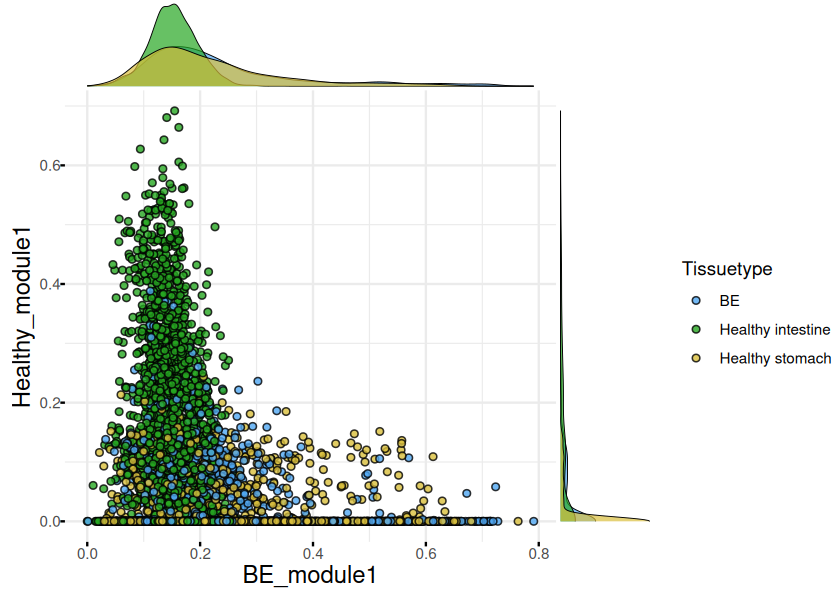

In [64]:


options(repr.plot.height = 5, repr.plot.width =7)


suppressWarnings({
 ggscatterhist(
    scatter_df,  x = module_name_class$BE[1], y = module_name_class$Healthy[1],  
    shape = 21, color = "black", fill = "Tissuetype", size = 1.5, alpha = 0.8, 
    palette = c("#50A7F2", "#26A621", "#D9BF3D"),
    margin.plot = "density",
    margin.params = list(fill = "Tissuetype", color = "black", size = 0.2),
    legend ='right',
    ggtheme = theme_minimal() +
      theme(  
        axis.title.x = element_text(size = 14, face = "plain"),
        axis.title.y = element_text(size = 14, face = "plain"),
        axis.text.x = element_blank(),
        axis.text.y = element_blank(), 
        scale_x_continuous(breaks = NULL),
        scale_y_continuous(breaks = NULL),
#           legend.position = "hidden" 
      )
  )
})


In [ ]:
# # options(repr.plot.height = 40, repr.plot.width =25)
# png('./03_scatter_plot_1_AUC.png',width = 25,height = 40,units = 'in',res = 400)
# plot_grid(plotlist = scatter_plot,ncol = 5)
# dev.off()

In [ ]:
# saveRDS(scatter_plot ,'./01_scatter_plot_AUC.rds')

In [ ]:
module_names <- readRDS('./01_module_names_AUC.rds')

scatter_df <- readRDS('./01_scatter_df_AUC.rds')

In [50]:
head(scatter_df)

Tissuetype        Tissue_in_paper
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   Healthy stomach   NGC            
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 BE                BSCJ           
SRR8513798-TTCTCAACAGTAACGG-1            Healthy intestine Rectum         
SRR8513795-ACGAGGAAGTATGACA-1            Healthy intestine Ileum          
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   Healthy stomach   NGC            
P6592_normal-CATCAAGGTCACTGGC-1          Healthy stomach   NGB            
                                         Detailed_Cell_Type         
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   Neck-Cells                 
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 Intestinal_Undifferentiated
SRR8513798-TTCTCAACAGTAACGG-1            Enterocytes_Intermediate   
SRR8513795-ACGAGGAAGTATGACA-1            Goblet                     
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   Foveolar_Differentiated    
P6592_normal-CATCAAGGTCACTGGC-1          Chief                      
                                         Healthy_module1 Healthy_module2
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.000000000     0.2266441      
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.000000000     0.1993559      
SRR8513798-TTCTCAACAGTAACGG-1            0.000000000     0.3218983      
SRR8513795-ACGAGGAAGTATGACA-1            0.000000000     0.2165424      
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.000000000     0.6129492      
P6592_normal-CATCAAGGTCACTGGC-1          0.001261034     0.1850508      
                                         Healthy_module3 Healthy_module4
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.09341376      0.32827737     
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.07419301      0.37988183     
SRR8513798-TTCTCAACAGTAACGG-1            0.13018439      0.47223423     
SRR8513795-ACGAGGAAGTATGACA-1            0.20638005      0.21643368     
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.29337110      0.03551184     
P6592_normal-CATCAAGGTCACTGGC-1          0.06122908      0.14957727     
                                         Healthy_module5 Healthy_module6
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.12522043      0.77091040     
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.13568706      0.81140907     
SRR8513798-TTCTCAACAGTAACGG-1            0.13257741      0.77158482     
SRR8513795-ACGAGGAAGTATGACA-1            0.14489277      0.60101631     
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.06699975      0.06322868     
P6592_normal-CATCAAGGTCACTGGC-1          0.09862720      0.59064624     
                                         Healthy_module7 ⋯ BE_module10
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.18296375      ⋯ 0.1882322  
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.25366738      ⋯ 0.1462978  
SRR8513798-TTCTCAACAGTAACGG-1            0.21078891      ⋯ 0.3134899  
SRR8513795-ACGAGGAAGTATGACA-1            0.55302772      ⋯ 0.3047998  
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.08358209      ⋯ 0.3373084  
P6592_normal-CATCAAGGTCACTGGC-1          0.07852878      ⋯ 0.1633672  
                                         BE_module11 BE_module12 BE_module14
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.10279831  0.11772297  0.2865772  
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.10373154  0.33154435  0.1788591  
SRR8513798-TTCTCAACAGTAACGG-1            0.21983822  0.10712175  0.1919463  
SRR8513795-ACGAGGAAGTATGACA-1            0.07582671  0.04771151  0.1010067  
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.04040850  0.08132425  0.4703859  
P6592_normal-CATCAAGGTCACTGGC-1          0.05252378  0.06712899  0.1916946  
                                         BE_module15 BE_module16 BE_module17
Patient21_SIGAC1_NG-GAGGGTAAGAACGCGT-1   0.7583730   0.08134962  0.2461402  
Patient03_SIGAB5_BSCJ-GACGTGCCACATCCAA-1 0.8489328   0.11713145  0.2760407  
SRR8513798-TTCTCAACAGTAACGG-1            0.8689773   0.03232972  0.3177236  
SRR8513795-ACGAGGAAGTATGACA-1            0.6248598   0.15531474  0.6113933  
Patient21_SIGAC1_NG-CTCATCGAGATAACGT-1   0.1413527   0.02095278  0.1160340  
P6

In [52]:
module_names <- colnames(scatter_df)[4:ncol(scatter_df)]

module_names

[1] "Healthy_module1"  "Healthy_module2"  "Healthy_module3"  "Healthy_module4" 
 [5] "Healthy_module5"  "Healthy_module6"  "Healthy_module7"  "Healthy_module8" 
 [9] "Healthy_module9"  "Healthy_module10" "Healthy_module11" "Healthy_module12"
[13] "Healthy_module13" "Healthy_module14" "Healthy_module15" "Healthy_module16"
[17] "BE_module1"       "BE_module3"       "BE_module4"       "BE_module5"      
[21] "BE_module6"       "BE_module7"       "BE_module8"       "BE_module10"     
[25] "BE_module11"      "BE_module12"      "BE_module14"      "BE_module15"     
[29] "BE_module16"      "BE_module17"      "BE_module18"      "BE_module19"     
[33] "BE_module21"

In [54]:
for (i in 1:(length(module_names) - 1)) {
    
  for (j in (i + 1):length(module_names)) {
      
    png(paste0('./03_scatter_AUC/', paste(module_names[i], module_names[j], sep = "_vs_"), '.png'), 
         width = 7, height = 5, units = 'in', res = 400)
      
    suppressWarnings({
        
      ggscatterhist(
        scatter_df, 
        x = module_names[i], 
        y = module_names[j], 
        shape = 21, 
        color = "black", 
        fill = "Tissuetype", 
        size = 1.5, 
        alpha = 0.8, 
        palette = c("#50A7F2", "#26A621", "#D9BF3D"), 
        margin.plot = "density", 
        margin.params = list(fill = "Tissuetype", color = "black", size = 0.2), 
        legend = 'right', 
        ggtheme = theme_minimal() + theme(
          axis.title.x = element_text(size = 14, face = "plain"), 
          axis.title.y = element_text(size = 14, face = "plain"), 
          axis.text.x = element_blank(), 
          axis.text.y = element_blank(), 
          scale_x_continuous(breaks = NULL), 
          scale_y_continuous(breaks = NULL), 
          legend.position = "hidden"
        )
      )
    })
      
    dev.off()
      
  }
}

In [55]:
saveRDS(module_names ,'./03_module_names_AUC.rds')

saveRDS(scatter_df, './03_scatter_df_AUC.rds')

# radar plot

In [68]:
length(radar_plot_df$module)

[1] 33

In [67]:
radar_plot_list  <-split(scatter_df ,scatter_df$Tissue_in_paper)

  radar_plot_df <- radar_plot_list[[1]][, -c(1,2)] %>% 
    dplyr::group_by(Detailed_Cell_Type) %>% 
    dplyr::summarise_all(mean) %>%
    as.data.frame() 

# radar_plot_df <- t(radar_plot_df) %>% as.data.frame

rownames(radar_plot_df) <- radar_plot_df$Detailed_Cell_Type

radar_plot_df <- dplyr::select(radar_plot_df, -Detailed_Cell_Type) 

radar_plot_df <- t(radar_plot_df) %>% as.data.frame()

radar_plot_df[radar_plot_df < 0] <- 0 

radar_plot_df$module <- rownames(radar_plot_df)

  radar_plot_df <- radar_plot_df[,c('module', colnames(radar_plot_df)[1:ncol(radar_plot_df)-1])]

In [80]:
mycolor <- c('#D916F2','#27A4F2','#F2CB05','#F29F05','#F25C05',
             
             '#D94169','#171559','#F2D0A7','#F29F80','#F26363',
             
             '#B3A815', '#1FC7FF','#FFF005','#FF1F59','#FFD3B6',
             
             '#DCEDC1', '#F24B88','#A8E6CF','#660373','#F28A80'
)


# be_colors <- scales::seq_gradient_pal('#fef5f0', "#990F0F")(seq(0, 1, length.out = sum(grepl("^BE_module", rownames(radar_plot_df)))))

# healthy_colors <- scales::seq_gradient_pal("#cac5e4", "#260F99")(seq(0, 1, length.out = sum(grepl("^Healthy", rownames(radar_plot_df)))))
 
# colors <- c(healthy_colors , be_colors)
colors <- data.frame('modules' =radar_plot_df$module ,'colors' =rep(mycolor,2)[1:33])


In [81]:
mycolor %>% length
colors

[1] 20

modules          colors 
1  Healthy_module1  #D916F2
2  Healthy_module2  #27A4F2
3  Healthy_module3  #F2CB05
4  Healthy_module4  #F29F05
5  Healthy_module5  #F25C05
6  Healthy_module6  #D94169
7  Healthy_module7  #171559
8  Healthy_module8  #F2D0A7
9  Healthy_module9  #F29F80
10 Healthy_module10 #F26363
11 Healthy_module11 #B3A815
12 Healthy_module12 #1FC7FF
13 Healthy_module13 #FFF005
14 Healthy_module14 #FF1F59
15 Healthy_module15 #FFD3B6
16 Healthy_module16 #DCEDC1
17 BE_module1       #F24B88
18 BE_module3       #A8E6CF
19 BE_module4       #660373
20 BE_module5       #F28A80
21 BE_module6       #D916F2
22 BE_module7       #27A4F2
23 BE_module8       #F2CB05
24 BE_module10      #F29F05
25 BE_module11      #F25C05
26 BE_module12      #D94169
27 BE_module14      #171559
28 BE_module15      #F2D0A7
29 BE_module16      #F29F80
30 BE_module17      #F26363
31 BE_module18      #B3A815
32 BE_module19      #1FC7FF
33 BE_module21      #FFF005

In [82]:
  plot_list <- list()


  for(i in 1:nrow(radar_plot_df)){
    cur_mod <- as.character(radar_plot_df[i,'module'])
    cur_color <- subset(colors, modules == cur_mod) %>% .$colors
    plot_list[[cur_mod]] <- ggradar::ggradar(
      radar_plot_df[i,], 
        group.colours=cur_color,
          grid.line.width = 0.25,
      draw.points=FALSE,
        grid.label.size = 3,
      fill=TRUE
      ) + 
      Seurat::NoLegend() + 
      ggtitle(cur_mod) + 
      theme(
        plot.title = element_text(face='plain', hjust=0.3)
      )
  }

In [83]:
radar_plot_list  <-split(scatter_df ,scatter_df$Tissue_in_paper)

length(radar_plot_list)

[1] 10

In [ ]:
# options(repr.plot.height = 35, repr.plot.width =47)  
#     png(paste0('./radar_plot_AUC/',names(radar_plot_list)[6],'.png'),width = 45,height = 45,units = 'in',res = 400)

patch <- wrap_plots(plot_list, 3)
patch+ 
  plot_annotation(
    title = names(radar_plot_list)[1],
    theme = theme(
      plot.title = element_text(size = 40, face = "bold", hjust = 1)
    )
  )

# dev.off()

In [85]:
plot_list_list <- list()

for(i in 1:length(radar_plot_list)){
    
    radar_plot_df <- radar_plot_list[[i]][, -c(1,2)] %>% 
    dplyr::group_by(Detailed_Cell_Type) %>% 
    dplyr::summarise_all(mean) %>%
    as.data.frame() 

# radar_plot_df <- t(radar_plot_df) %>% as.data.frame

rownames(radar_plot_df) <- radar_plot_df$Detailed_Cell_Type

radar_plot_df <- dplyr::select(radar_plot_df, -Detailed_Cell_Type) 

radar_plot_df <- t(radar_plot_df) %>% as.data.frame()

radar_plot_df[radar_plot_df < 0] <- 0 

radar_plot_df$module <- rownames(radar_plot_df)

  radar_plot_df <- radar_plot_df[,c('module', colnames(radar_plot_df)[1:ncol(radar_plot_df)-1])]
    
 plot_list <- list()


  for(j in 1:nrow(radar_plot_df)){
    cur_mod <- as.character(radar_plot_df[j,'module'])
    cur_color <- subset(colors, modules == cur_mod) %>% .$colors
    plot_list[[cur_mod]] <- ggradar::ggradar(
      radar_plot_df[j,], 
        group.colours=cur_color,
          grid.line.width = 0.25,
        grid.label.size = 3,
      draw.points=FALSE,
      fill=TRUE
      ) + 
      Seurat::NoLegend() + 
      ggtitle(cur_mod) + 
      theme(
        plot.title = element_text(face='plain', hjust=0.3)
      )
  }
    
 plot_list_list[[i]] <- plot_list
    


    
    print(i)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


In [86]:
for(i in 1 :length(plot_list_list))    {
    
#      png(paste0('./radar_plot_AUC/',names(radar_plot_list)[i],'.png'),width = 45,height = 45,units = 'in',res = 250)
    
        patch <- wrap_plots(plot_list_list[[i]], 3)
p <- patch+ 
  plot_annotation(
    title = names(radar_plot_list)[i],
    theme = theme(
      plot.title = element_text(size = 40, face = "bold", hjust = 0.5)
    )
  )
#     dev.off()
    
    ggsave(filename = paste0('./04_radar_plot_AUC/',names(radar_plot_list)[i],'.pdf'),plot = p ,width = 45,height = 45,units = 'in',dpi = 400)
    
 ggsave(filename = paste0('./04_radar_plot_AUC/',names(radar_plot_list)[i],'.png'),plot = p ,width = 45,height = 45,units = 'in',dpi = 300)

}
   

In [87]:
identical(rownames(BE_moduleScore),rownames(t(moduleScore)))

heatmapdf <- cbind(AllTissue_merge@meta.data[,c('Detailed_Cell_Type','Tissue_in_paper')],cbind(BE_moduleScore,t(moduleScore)))

dim(heatmapdf)

head(heatmapdf)

saveRDS(heatmapdf , './05_heatmapdf.rds')

[1] TRUE

[1] 79522    35

Detailed_Cell_Type          Tissue_in_paper
SRR8513799-CTCACACGTCACCCAG-1 Enterocytes_Intermediate    Rectum         
SRR8513799-TACAGTGGTCATCCCT-1 Intestinal_Undifferentiated Rectum         
SRR8513799-GCACATACACTGTCGG-1 Enterocytes_Intermediate    Rectum         
SRR8513799-CTGAAACTCTGGCGAC-1 Intestinal_Undifferentiated Rectum         
SRR8513799-AGTAGTCAGTGAAGAG-1 Goblet                      Rectum         
SRR8513799-ATCCGAACAACGATGG-1 Goblet                      Rectum         
                              BE_module1 BE_module3 BE_module4 BE_module5
SRR8513799-CTCACACGTCACCCAG-1 0.1550850  0.2526822  0.06129739 0.2188196 
SRR8513799-TACAGTGGTCATCCCT-1 0.1316673  0.2318313  0.19529913 0.2978776 
SRR8513799-GCACATACACTGTCGG-1 0.1674745  0.1851385  0.16516075 0.2135012 
SRR8513799-CTGAAACTCTGGCGAC-1 0.1839847  0.1943278  0.14726983 0.3199673 
SRR8513799-AGTAGTCAGTGAAGAG-1 0.1839111  0.2218957  0.15750608 0.1803542 
SRR8513799-ATCCGAACAACGATGG-1 0.1229569  0.2474111  0.34851259 0.1746896 
                              BE_module6 BE_module7 BE_module8 BE_module10 ⋯
SRR8513799-CTCACACGTCACCCAG-1 0.2493345  0.4448295  0.1777360  0.6041700   ⋯
SRR8513799-TACAGTGGTCATCCCT-1 0.2890661  0.5235595  0.1272618  0.3631629   ⋯
SRR8513799-GCACATACACTGTCGG-1 0.3029051  0.5326612  0.1636309  0.3497916   ⋯
SRR8513799-CTGAAACTCTGGCGAC-1 0.2393197  0.4522159  0.1175674  0.2070269   ⋯
SRR8513799-AGTAGTCAGTGAAGAG-1 0.2302345  0.3631240  0.1599127  0.3584437   ⋯
SRR8513799-ATCCGAACAACGATGG-1 0.4248046  0.6117062  0.3250188  0.3044256   ⋯
                              Healthy_module7 Healthy_module8 Healthy_module9
SRR8513799-CTCACACGTCACCCAG-1 0.1405970       0.2527599       0.08333333     
SRR8513799-TACAGTGGTCATCCCT-1 0.1552026       0.3008029       0.07220352     
SRR8513799-GCACATACACTGTCGG-1 0.1676972       0.3083297       0.09605312     
SRR8513799-CTGAAACTCTGGCGAC-1 0.1508529       0.2404731       0.07201646     
SRR8513799-AGTAGTCAGTGAAGAG-1 0.4907463       0.2143369       0.02431725     
SRR8513799-ATCCGAACAACGATGG-1 0.5504691       0.3874982       0.15852974     
                              Healthy_module10 Healthy_module11
SRR8513799-CTCACACGTCACCCAG-1 0.14217210       0.00000000      
SRR8513799-TACAGTGGTCATCCCT-1 0.10198830       0.00000000      
SRR8513799-GCACATACACTGTCGG-1 0.09152047       0.00000000      
SRR8513799-CTGAAACTCTGGCGAC-1 0.27314954       0.00000000      
SRR8513799-AGTAGTCAGTGAAGAG-1 0.06631579       0.04488014      
SRR8513799-ATCCGAACAACGATGG-1 0.04970760       0.17002374      
                              Healthy_module12 Healthy_module13
SRR8513799-CTCACACGTCACCCAG-1 0.03812480       0.9555028       
SRR8513799-TACAGTGGTCATCCCT-1 0.04003941       0.8739374       
SRR8513799-GCACATACACTGTCGG-1 0.06299608       0.9543540       
SRR8513799-CTGAAACTCTGGCGAC-1 0.08941019       0.9762579       
SRR8513799-AGTAGTCAGTGAAGAG-1 0.08747700       0.9485334       
SRR8513799-ATCCGAACAACGATGG-1 0.02981579       0.9793214       
                              Healthy_module14 Healthy_module15
SRR8513799-CTCACACGTCACCCAG-1 0.3021110        0.13327722      
SRR8513799-TACAGTGGTCATCCCT-1 0.4024253        0.12785260      
SRR8513799-GCACATACACTGTCGG-1 0.4344533        0.12196034      
SRR8513799-CTGAAACTCTGGCGAC-1 0.1824188        0.13879536      
SRR8513799-AGTAGTCAGTGAAGAG-1 0.1789944        0.07949869      
SRR8513799-ATCCGAACAACGATGG-1 0.2072758        0.09595960      
                              Healthy_module16
SRR8513799-CTCACACGTCACCCAG-1 0.1805042       
SRR8513799-TACAGTGGTCATCCCT-1 0.1789916       
SRR8513799-GCACATACACTGTCGG-1 0.2868908       
SRR8513799-CTGAAACTCTGGCGAC-1 0.3287395       
SRR8513799-AGTAGTCAGTGAAGAG-1 0.1702521       
SRR8513799-ATCCGAACAACGATGG-1 0.1630252

In [5]:
ls()

[1] "AllTissue_merge"      "d_palettes"           "mycol"               
[4] "plot_umap_for_module"

In [6]:
heatmapdf <- readRDS('./05_heatmapdf.rds')

In [7]:
AllTissue_merge[["module_AUC"]] <- CreateAssayObject(t(heatmapdf[,-c(1:2)]))

DefaultAssay(AllTissue_merge) <- 'module_AUC'

mergeData.list <-SplitObject(object = AllTissue_merge,split.by ='Tissue_in_paper' ) 

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [ ]:
# heatmap_list_scoreO <- list()

# for (idx in seq_along(mergeData.list)) {

# #     celltype.list <- SplitObject(object = mergeData.list[[idx]], split.by = 'Detailed_Cell_Type')
#      celltype.list <-split(mergeData.list[[idx]][,-2],mergeData.list[[idx]]$Detailed_Cell_Type )
  
# scoreO <- sapply(celltype.list, FUN = function(x) { rowMeans(x[,-1], na.rm = TRUE) })
#         scoreO <- do.call(cbind, scoreO)

# heatmap_list_scoreO[[idx]] <- pheatmap(
#    scoreO,
#     name = 'Enrich score',
#     main = names(mergeData.list)[[idx]],
#     cluster_cols = TRUE,
#     cluster_rows = TRUE,
# #     display_numbers = ifelse(enrichScore_P_list[[i]] <= 0.001, "**", ifelse(enrichScore_P_list[[i]] <= 0.01, '*', '')),
#     legend_breaks = c(-1, 1),
#     treeheight_row = 0,
#     treeheight_col = 0,
#     legend_labels = c("low", "high"),
#     cutree_cols = 4,
#     cutree_rows = 4
#   )

    
# }


In [8]:
heatmap_list_scoreO <- list()

for (idx in seq_along(mergeData.list)) {


    tryCatch({

        celltype.list <- SplitObject(object = mergeData.list[[idx]], split.by = 'Detailed_Cell_Type')
      

        scoreO <- lapply(celltype.list, function(x) {

            if (is.null(dim(x)) || ncol(x) < 2) {
                return(NULL)  # Skip objects with insufficient dimensions
            }
            rowMeans(x, na.rm = TRUE)
        })
      
        # Remove NULL elements from the list
        scoreO <- Filter(Negate(is.null), scoreO)
      
        # Convert the list to a matrix
        scoreO <- do.call(cbind, scoreO)
      
        # Generate the heatmap
        heatmap_list_scoreO[[idx]] <- pheatmap(
            scoreO,
            name = 'AUC score',
            main = names(mergeData.list)[[idx]],
            cluster_cols = TRUE,
            cluster_rows = TRUE,
            legend_breaks = c(-1, 1),
            treeheight_row = 0,
            treeheight_col = 0,
            legend_labels = c("low", "high"),
            cutree_cols = 4,
            cutree_rows = 4
        )
    }, error = function(e) {

        message("Error in iteration ", idx, ": ", e$message)
    })
}


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




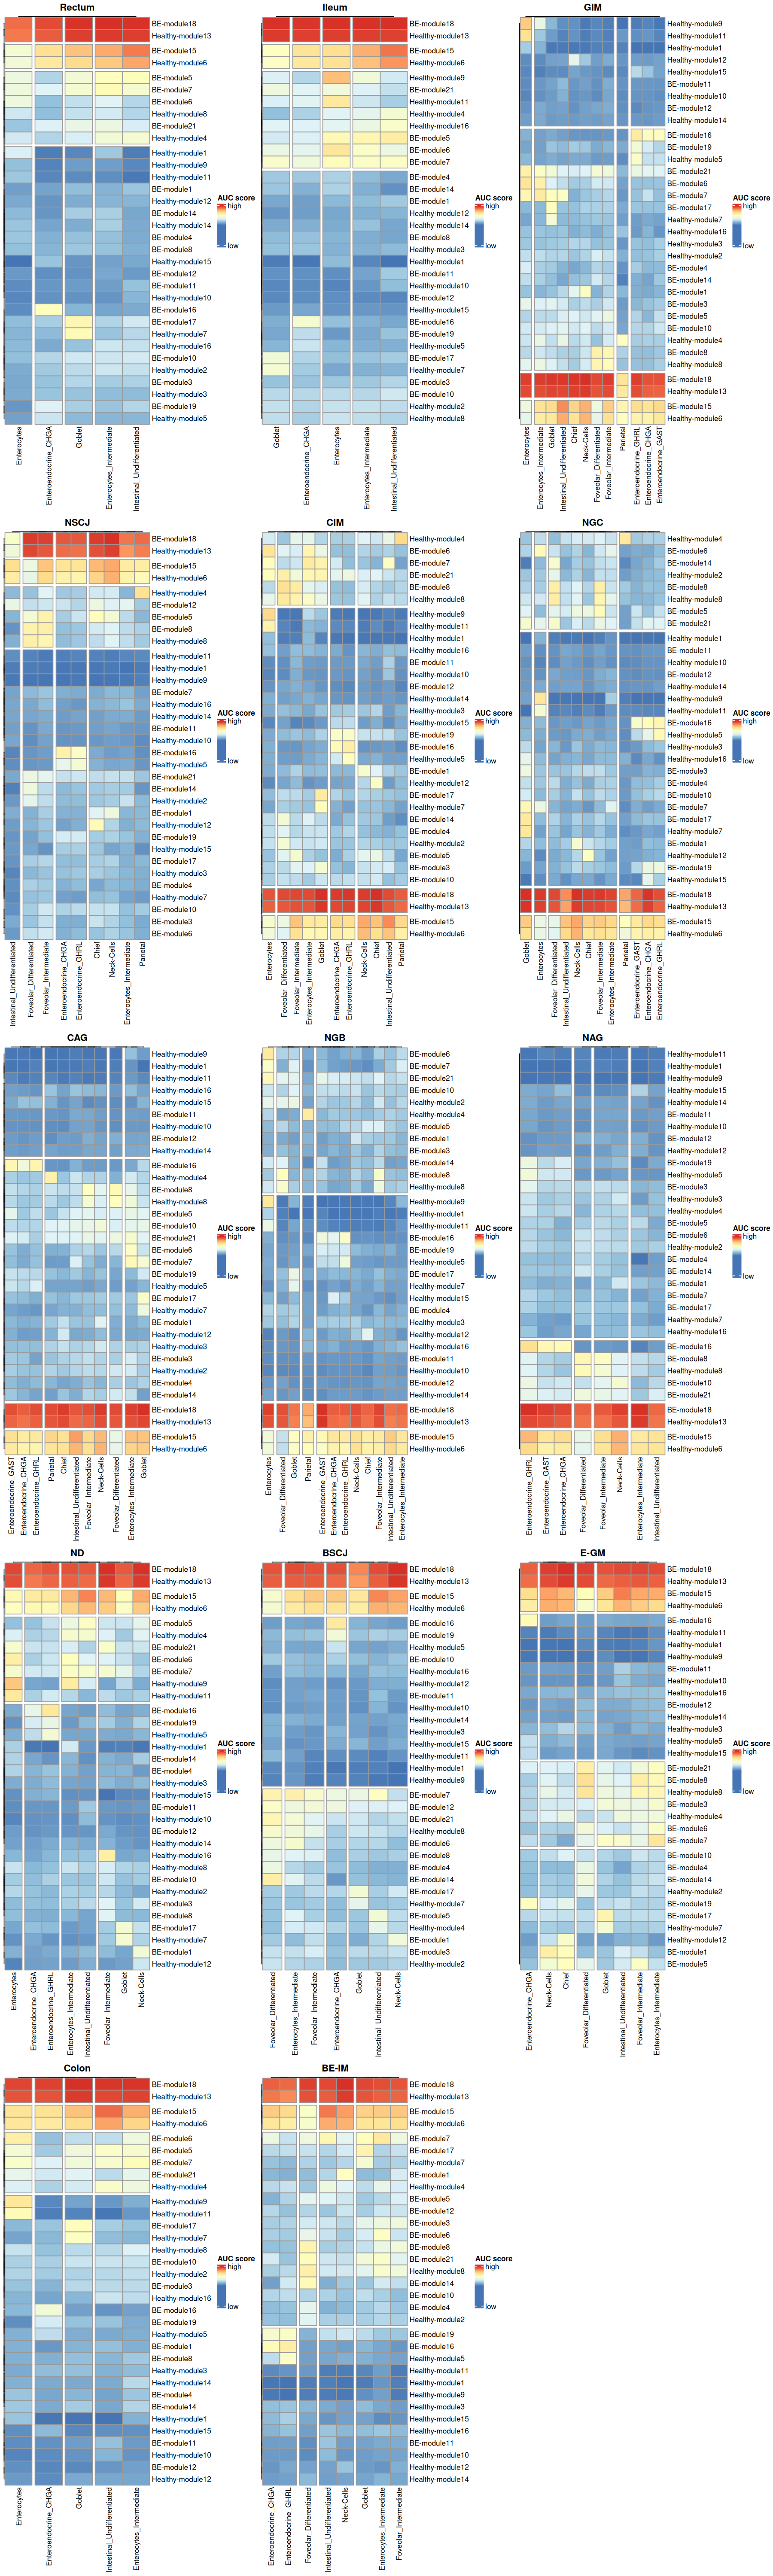

In [9]:
library(gridExtra)
options(repr.plot.height = 50, repr.plot.width =15)  
grob_list <- lapply(heatmap_list_scoreO, function(h) grid.grabExpr(draw(h)))
do.call(grid.arrange, c(grobs = grob_list, ncol = 3))  


In [10]:
pdf("./05_combined_heatmaps.pdf", width = 15, height = 50)  
do.call(grid.arrange, c(grobs = grob_list, ncol = 3))  
dev.off()

pdf 
  2

In [12]:
png("./05_combined_heatmaps.png", width = 15, height = 50,units = 'in',res = 500)  
do.call(grid.arrange, c(grobs = grob_list, ncol = 3))  
dev.off()

pdf 
  2